In [10]:
from openai import OpenAI
import tiktoken

from pytrial.data.demo_data import load_trial_outcome_data
from pytrial.data.trial_data import TrialOutcomeDatasetBase

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import requests
from dotenv import load_dotenv
import traceback
from typing import Iterable
from tqdm import tqdm
import json
from datetime import datetime
import os

In [11]:
def get_length(model, text):
    assert model == "gpt-3.5-turbo" or model == "gpt-4-0125-preview"
    encoder = tiktoken.encoding_for_model(model)
    token_cnt = len(encoder.encode(text))
    return token_cnt

def get_pricing(direction, model, text):
    assert (model == "gpt-3.5-turbo" or model == "gpt-4-0125-preview") and (direction == "in" or direction == "out")
    token_cnt = get_length(model, text)
    if direction == "in":
        return (token_cnt * 0.01 / 1e3 if model == "gpt-4-0125-preview" else token_cnt * 0.0005 / 1e3)
    else:
        return (token_cnt * 0.03 / 1e3 if model == "gpt-4-0125-preview" else token_cnt * 0.0015 / 1e3)

In [12]:
load_dotenv()
assert os.getenv("OPENAI_API_KEY") is not None

client = OpenAI()

def get_assistant_msg(content: str):
    return {"role": "assistant",
            "content": content}

def pipe_qa_chat(trial: str, base_messages: list, summary_prompt: str, model: str, tool_data: dict, questions = None):
    
    trial_message = {"role": "user",
                     "content": f"The trial data is the following.\n{trial}\nLet's explain this clinical trial for predicting its success. Let's examine, step by step."}
    
    messages = base_messages.copy()
    messages.append(trial_message)
    history = messages.copy()
    response = get_assistant_msg(get_response(history, model, None))
    history.append(response)

    question_responses = []
    for question in questions:
        question_responses.append(question)
        response = get_assistant_msg(get_response(
            messages + [question], model, None))
        question_responses.append(response)

    history += question_responses

    summary_message = {"role": "user",
                       "content": f"{summary_prompt} With that in mind, predict the outcome of this clinical trial. Let's examine, step by step."}
    
    history.append(summary_message)
    response = get_response(history, model, tool_data)

    return response


def get_response(messages: list, model: str, tool_data: dict):
    # print(len(messages))
    # return {"reasoning": "", "prediction": ""}

    if tool_data is not None:
        tools = [
            {
                "type": "function",
                "function": {
                    "name": "predict_trial_outcome",
                    "description": tool_data.get("description"),
                    "parameters": tool_data.get("parameters")
                }
            }
        ]
    
        completion = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=tools,
            tool_choice="auto",
            temperature=0,
        )

    else:
        completion = client.chat.completions.create(
            model=model,
            messages=messages
        )

    assert completion.choices is not None

    message = completion.choices[0].message
    if message.tool_calls is not None:
        tool_calls = message.tool_calls
        response = tool_calls[0].function.arguments
    else:
        response = message.content

    if response is None:
        raise ValueError(f"Invalid response structure: {completion}")

    return response

In [17]:
results_folder = "../../results/gpt"
results_file = "gpt4-phase3-subtasks+clinical_knowledge+augmented_data.json"
model = "gpt-4-0125-preview"
limit = 30

In [18]:
def serialize_row(row: pd.Series) -> str:
    text_values = []
    for colname, value in row.items():
        text_values.append(f"{colname} is {value if value is not None else 'unknown'}")

    return ", ".join(text_values) + "."

In [19]:
def get_nct_data(nct_ids: list[str]):
    url_prefix = "https://clinicaltrials.gov/api/v2/studies"
    headers = {
        "accept": "application/json",
    }

    query_enc_ids = ["%22" + nct_id + "%22" for nct_id  in nct_ids]
    query = "?query.id=" + "+OR+".join(query_enc_ids) + "&pageSize=200"

    try:
        response = requests.get(f"{url_prefix}{query}", headers=headers)

        if response.status_code == 200:
            trial_data = response.json()
            trials = []

            print(f"Study count: {len(trial_data['studies'])}")

            for study in trial_data['studies']:
                identificationModule = study.get('protocolSection', {}).get('identificationModule', {})
                sponsorCollaboratorsModule = study.get('protocolSection', {}).get('sponsorCollaboratorsModule', {})
                descriptionModule = study.get('protocolSection', {}).get('descriptionModule', {})
                designModule = study.get('protocolSection', {}).get('designModule', {})
                contactsLocationsModule = study.get('protocolSection', {}).get('contactsLocationsModule', {})

                extracted_trial = {
                    "nctId": identificationModule.get("nctId"),
                    "description": descriptionModule.get("briefSummary"),
                    "lead_sponsor": sponsorCollaboratorsModule.get("leadSponsor", {}).get("name"),
                    "collaborators": [collaborator.get("name") for collaborator in sponsorCollaboratorsModule.get("collaborators", [])],
                    "study_type": designModule.get("studyType"),
                    "location_count": len(contactsLocationsModule.get("locations", [])),
                }
                trials.append(extracted_trial)
            return trials
        else:
            print(f"Request failed with status code: {response.status_code}")
            return None
    except requests.RequestException as e:
        print(f"Request exception occurred: {e}")
        return None

In [20]:
df = load_trial_outcome_data(phase='III', split='test')['data']

test_data = TrialOutcomeDatasetBase(df).data

successful_trials = test_data[test_data['label']
                           == 1].sample(n=limit//2, random_state=42)
failed_trials = test_data[test_data['label']
                           == 0].sample(n=limit - limit//2, random_state=42)

test_data = pd.concat(
    [successful_trials, failed_trials]).sample(frac=1, random_state=42)

nct_ids = test_data['nctid'].unique().tolist()
augmented_data = get_nct_data(nct_ids)
augmented_df = pd.DataFrame(augmented_data)
test_data = test_data.merge(augmented_df, left_on='nctid', right_on='nctId', how='left')

remaining_data = test_data[~test_data.index.isin(test_data.index)]

outcomes = test_data[['nctid', 'label', 'why_stop', 'status']]
test_data.drop(['smiless', 'label', 'why_stop',
               'study_first_submitted_date', 'nctid', 'status'], axis=1, inplace=True)

serialized_trials = test_data.apply(serialize_row, axis=1)

Study count: 30


In [22]:
with open("prompts.json", "r") as file:
    prompts = json.load(file)

prompt = prompts['templates']['subtasks+clinical_knowledge']

base_messages = prompt['base_messages']
summary_prompt = prompt['summary_prompt']
tool_data = prompt['tool_data']
questions = prompt['questions']


with open(f"{results_folder}/{results_file}", "w") as file:
    json.dump([], file)

def process_trial(trial, outcome):
    idx, outcome = outcome
    
    try:
        res = pipe_qa_chat(
            trial, base_messages, summary_prompt, model, tool_data, questions)

        response = json.loads(res) if isinstance(res, str) else res
        response['ground_truth'] = "success" if outcome.get(
            'label') == 1 else "failure"
        response['nctid'] = outcome.get('nctid')
        if str(outcome["why_stop"]).lower() != "nan":
            response["fail_reason"] = outcome["why_stop"] 

        with open(f"{results_folder}/{results_file}", "r+") as file:
            file_data = json.load(file)
            file_data.append(response)
            file.seek(0)
            json.dump(file_data, file, indent=4)
            file.truncate()

    except Exception as e:
        print(f"Error processing trial {outcome.get('nctid', 'Unknown')}: {e}")
        log_error(e, outcome)


def log_error(exception, outcome):
    error_message = {
        "trial_id": outcome.get('nctid', 'unknown'),
        "error": str(exception),
        "stack_trace": traceback.format_exc(),
        "time": datetime.now().isoformat()
    }

    with open(f"{results_folder}/error_log.json", "a+") as error_file:
        error_file.seek(0)
        try:
            errors = json.load(error_file)
        except json.JSONDecodeError:
            errors = []
        errors.append(error_message)
        error_file.seek(0)
        json.dump(errors, error_file, indent=4)
        error_file.truncate()

for trial, outcome in tqdm(zip(serialized_trials[:limit], outcomes.iterrows())):
    process_trial(trial, outcome)

30it [35:11, 70.37s/it]


In [23]:
preds = pd.read_json(f"{results_folder}/{results_file}")

preds['prediction'] = preds['prediction'].apply(
    lambda x: 'failure' if x != 'success' else 'success')
preds['ground_truth'] = preds['ground_truth'].apply(
    lambda x: 'failure' if x != 'success' else 'success')

le = LabelEncoder()
y_true = le.fit_transform(preds['ground_truth'])
y_pred = le.transform(preds['prediction'])


def calculate_metrics(y_true, y_pred):
    metrics = {}
    metrics['Acc'] = accuracy_score(y_true, y_pred)
    metrics['F1'] = f1_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred)
    metrics['PR-AUC'] = average_precision_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['Specificity'] = tn / (tn + fp)

    return metrics


metrics = calculate_metrics(y_true, y_pred)
print(metrics)

{'Acc': 0.6, 'F1': 0.7142857142857143, 'Precision': 0.5555555555555556, 'Recall': 1.0, 'ROC-AUC': 0.6, 'PR-AUC': 0.5555555555555556, 'Specificity': 0.2}


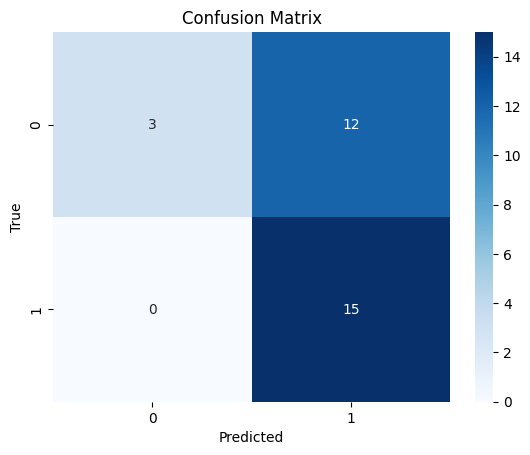

In [26]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

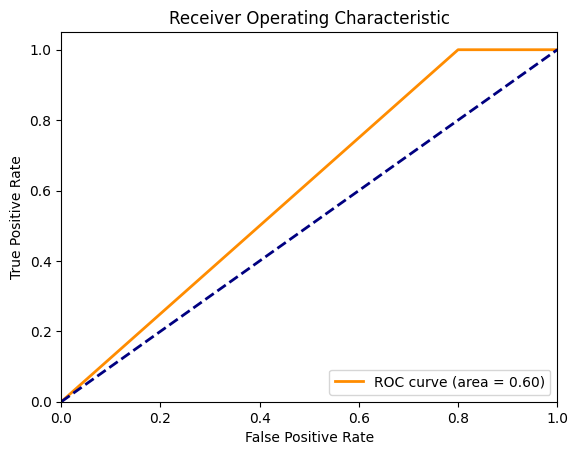

In [25]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()